# Capstone 2 on Airline Delays: Preprocessing
5/15/23

From our data wrangling and exploratory analysis, we've learned some interesting things about our data: what time of year flights are likely to get delayed/cancelled, which airlines are the worst offenders, etc. Recall that we're just looking at flights leaving RDU airport from Jul 2021-Jun 2022. Again, our data is from here: https://www.transtats.bts.gov/DL_SelectFields.aspx?gnoyr_VQ=FGK&QO_fu146_anzr=b0-gvzr.

Now let's get our data into shape so we can do some modeling with it.

In [1]:
# Note: we're using a virtual environment "capstone2venv" for this nb
# Need to pip install a number of packages: pandas, matplotlib, seaborn, imblearn

#Import necessary packages and load dataset
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

df_RDU = pd.read_csv("../Data/Interim/RDU_departures.csv")

In [2]:
df_RDU

,Unnamed: 0,QUARTER,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,FL_DATE,CARRIER,FL_NUM,ORIGIN,ORIGIN_CITY,...,CANCELLED,CRS_ELAPSED_TIME,ACTUAL_ELAPSED_TIME,AIR_TIME,DISTANCE,CARRIER_DELAY,WEATHER_DELAY,NAS_DELAY,SECURITY_DELAY,LATE_AIRCRAFT_DELAY
0,0,3,7,2,Friday,2021-07-02,SkyWest Airlines,3242,RDU,"Raleigh/Durham, NC",...,Not Cancelled,150.0,165.0,107.0,646.0,0.0,0.0,0.0,0.0,33.0
1,1,3,7,6,Tuesday,2021-07-06,SkyWest Airlines,3242,RDU,"Raleigh/Durham, NC",...,Not Cancelled,150.0,164.0,97.0,646.0,NaN,NaN,NaN,NaN,NaN
2,2,3,7,13,Tuesday,2021-07-13,SkyWest Airlines,3242,RDU,"Raleigh/Durham, NC",...,Not Cancelled,150.0,147.0,99.0,646.0,0.0,0.0,0.0,0.0,70.0
3,3,3,7,5,Monday,2021-07-05,SkyWest Airlines,3242,RDU,"Raleigh/Durham, NC",...,Not Cancelled,150.0,126.0,99.0,646.0,NaN,NaN,NaN,NaN,NaN
4,4,3,7,8,Thursday,2021-07-08,SkyWest Airlines,3242,RDU,"Raleigh/Durham, NC",...,Not Cancelled,150.0,161.0,127.0,646.0,0.0,0.0,0.0,0.0,84.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52640,52640,2,6,3,Friday,2022-06-03,Republic Airline,3598,RDU,"Raleigh/Durham, NC",...,Not Cancelled,114.0,116.0,68.0,416.0,NaN,NaN,NaN,NaN,NaN
52641,52641,2,6,2,Thursday,2022-06-02,Republic Airline,3657,RDU,"Raleigh/Durham, NC",...,Cancelled,116.0,NaN,NaN,416.0,NaN,NaN,NaN,NaN,NaN
52642,52642,2,6,2,Thursday,2022-06-02,Republic Airline,3599,RDU,"Raleigh/Durham, NC",...,Not Cancelled,156.0,118.0,95.0,646.0,16.0,0.0,0.0,0.0,250.0
52643,52643,2,6,1,Wednesday,2022-06-01,Republic Airline,3657,RDU,"Raleigh/Durham, NC",...,Cancelled,115.0,NaN,NaN,416.0,NaN,NaN,NaN,NaN,NaN


In [3]:
df_RDU.drop(['Unnamed: 0'], axis=1, inplace=True)

In [4]:
df_RDU.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52645 entries, 0 to 52644
Data columns (total 33 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   QUARTER              52645 non-null  int64  
 1   MONTH                52645 non-null  int64  
 2   DAY_OF_MONTH         52645 non-null  int64  
 3   DAY_OF_WEEK          52645 non-null  object 
 4   FL_DATE              52645 non-null  object 
 5   CARRIER              52645 non-null  object 
 6   FL_NUM               52645 non-null  int64  
 7   ORIGIN               52645 non-null  object 
 8   ORIGIN_CITY          52645 non-null  object 
 9   ORIGIN_STATE         52645 non-null  object 
 10  DEST                 52645 non-null  object 
 11  DEST_CITY            52645 non-null  object 
 12  DEST_STATE           52645 non-null  object 
 13  CRS_DEP_TIME         52645 non-null  object 
 14  DEP_TIME             51170 non-null  object 
 15  DEP_DELAY            51175 non-null 

## Creating a Result column
Up to now, we've had two dependent variable results: flight delays >15 min and flight cancellations. We really need to commit to one result column! Let's create one categorical variable "RESULT" that captures both of these. 

What if we combine DEP_DELAY_GROUP with CANCELLED?

DEP_DELAY_GROUP              

                    -2=delay of <-15 min
                  -1=delay between -15 and -1 min
                     0=delay between 0 and 14 min
                    1=delay between 15 and 29 min
                    2=delay between 30 and 44 min
                all the way to 12=delay >=180 min

Let's make a new RESULT group like so:

                0 = no delay
                1 = delay of 1 hour or less
                2 = delay of 2 hours or less
                3 = delay of more than 2 hours
                4 = cancelled

In [5]:
df_RDU['RESULT']=0
df_RDU.loc[(df_RDU['DEP_DELAY_GROUP']>0) & (df_RDU['DEP_DELAY_GROUP']<4), 'RESULT']=1
df_RDU.loc[(df_RDU['DEP_DELAY_GROUP']>4) & (df_RDU['DEP_DELAY_GROUP']<12), 'RESULT']=2
df_RDU.loc[df_RDU['DEP_DELAY_GROUP']==12, 'RESULT']=3
df_RDU.loc[df_RDU['DEP_DELAY_GROUP'].isna(), 'RESULT']=4

In [6]:
df_RDU['RESULT'].value_counts()

RESULT
0    42945
1     5551
2     1903
4     1470
3      776
Name: count, dtype: int64

In [7]:
df_RDU['RESULT'].isna().sum()

0

Now we have a column 'RESULT' which tells us how delayed a flight was (-2 through 12) or if it was cancelled (13).

## Getting rid of duplicate variables

I was hesitant to get rid of variables before. But we need to delete certain duplicate ones so we don't have problems with collinearity/redundant data.

Let's look at what data we have and what types.

In [8]:
df_RDU.dtypes

QUARTER                  int64
MONTH                    int64
DAY_OF_MONTH             int64
DAY_OF_WEEK             object
FL_DATE                 object
CARRIER                 object
FL_NUM                   int64
ORIGIN                  object
ORIGIN_CITY             object
ORIGIN_STATE            object
DEST                    object
DEST_CITY               object
DEST_STATE              object
CRS_DEP_TIME            object
DEP_TIME                object
DEP_DELAY              float64
DEP_DEL15               object
DEP_DELAY_GROUP        float64
CRS_ARR_TIME            object
ARR_TIME                object
ARR_DELAY              float64
ARR_DEL15               object
ARR_DELAY_GROUP        float64
CANCELLED               object
CRS_ELAPSED_TIME       float64
ACTUAL_ELAPSED_TIME    float64
AIR_TIME               float64
DISTANCE               float64
CARRIER_DELAY          float64
WEATHER_DELAY          float64
NAS_DELAY              float64
SECURITY_DELAY         float64
LATE_AIR

First let's fix some dtypes.

In [9]:
df_RDU['QUARTER'] = df_RDU['QUARTER'].astype('category')
df_RDU['MONTH'] = df_RDU['MONTH'].astype('category')
df_RDU['DAY_OF_MONTH'] = df_RDU['DAY_OF_MONTH'].astype('category')
df_RDU['DAY_OF_WEEK'] = df_RDU['DAY_OF_WEEK'].astype('category')
# df_RDU['FL_DATE'] = df_RDU['FL_DATE'].astype('datetime64') # not sure if this one works
df_RDU['FL_NUM'] = df_RDU['FL_NUM'].astype('object')
# df_RDU['CRS_DEP_TIME'] = pd.to_datetime(df_RDU['CRS_DEP_TIME'], format='%H:%M', errors='coerce').dt.time
# df_RDU['DEP_TIME'] = pd.to_datetime(df_RDU['DEP_TIME'], format='%H%M', errors='coerce').dt.time
df_RDU['RESULT'] = df_RDU['RESULT'].astype('category')

We already have month and day of the month so let's get rid of 'FL_DATE.'

We don't need 'ORIGIN', 'ORIGIN_CITY', and 'ORIGIN_STATE': we have subsetted our data so that we're only working with RDU.

We only need 'DEST' (destination airport code), 'DEST_CITY', and 'DEST_STATE' are redundant.

We have 'RESULT' so we don't need 'DEP_DELAY', 'DEP_DEL15', 'DEP_DELAY_GROUP', 'ARR_DELAY', 'ARR_DEL15', 'ARR_DELAY_GROUP', and 'CANCELLED' anymore.

DEP_TIME is very close to CRS_DEP_TIME; ARR_TIME and CRS_DEP_TIME are very close; and ACTUAL_ELAPSED_TIME, AIR_TIME, and CRS_ELAPSED_TIME are also very close. Let's drop the actual times and keep the scheduled times.

Finally, we need to drop 'CARRIER_DELAY', 'WEATHER_DELAY', 'NAS_DELAY', 'SECURITY_DELAY', and 'LATE_AIRCRAFT_DELAY' since these will be collinear with our 'RESULT' column..

In [10]:
df_RDU2 = df_RDU.drop(columns=['FL_DATE', 'ORIGIN', 'ORIGIN_CITY', 'ORIGIN_STATE', 'DEST_CITY', 'DEST_STATE',
                              'DEP_TIME', 'DEP_DELAY', 'DEP_DEL15', 'DEP_DELAY_GROUP', 
                               'ARR_TIME', 'ARR_DELAY', 'ARR_DEL15', 'ARR_DELAY_GROUP', 
                               'ACTUAL_ELAPSED_TIME', 'AIR_TIME', 'CANCELLED',
                              'CARRIER_DELAY', 'WEATHER_DELAY', 'NAS_DELAY', 'SECURITY_DELAY', 'LATE_AIRCRAFT_DELAY'])
df_RDU2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52645 entries, 0 to 52644
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   QUARTER           52645 non-null  category
 1   MONTH             52645 non-null  category
 2   DAY_OF_MONTH      52645 non-null  category
 3   DAY_OF_WEEK       52645 non-null  category
 4   CARRIER           52645 non-null  object  
 5   FL_NUM            52645 non-null  object  
 6   DEST              52645 non-null  object  
 7   CRS_DEP_TIME      52645 non-null  object  
 8   CRS_ARR_TIME      52626 non-null  object  
 9   CRS_ELAPSED_TIME  52645 non-null  float64 
 10  DISTANCE          52645 non-null  float64 
 11  RESULT            52645 non-null  category
dtypes: category(5), float64(2), object(5)
memory usage: 3.1+ MB


Let's do some "binning" for CRS_DEP_TIME and CRS_ARR_TIME.

        Morning: 3:01am to 9am (030100 to 090000)
        Midday: 9:01am to 3pm (090100 to 150000)
        Afternoon_Evening: 3:01pm to 9pm (150100 to 210000)
        Late_Night: 9:01pm to 3am (210100 to 030000)

In [11]:
# first we have to do some cleanup

df_RDU2['CRS_DEP_TIME'] = df_RDU2['CRS_DEP_TIME'].str.replace(':','')
df_RDU2['CRS_DEP_TIME'] = pd.to_numeric(df_RDU2['CRS_DEP_TIME'])
df_RDU2['CRS_ARR_TIME'] = df_RDU2['CRS_ARR_TIME'].str.replace(':','')
df_RDU2['CRS_ARR_TIME'] = pd.to_numeric(df_RDU2['CRS_ARR_TIME'])

In [12]:
df_RDU2.loc[df_RDU2['CRS_DEP_TIME'] <= 240000, 'DEP_TIME_BINS'] = 'LATE_NIGHT'
df_RDU2.loc[df_RDU2['CRS_DEP_TIME'] <= 210000, 'DEP_TIME_BINS'] = 'AFTERNOON_EVENING'
df_RDU2.loc[df_RDU2['CRS_DEP_TIME'] <= 150000, 'DEP_TIME_BINS'] = 'MIDDAY'
df_RDU2.loc[df_RDU2['CRS_DEP_TIME'] <= 90000, 'DEP_TIME_BINS'] = 'MORNING'
df_RDU2.loc[df_RDU2['CRS_DEP_TIME'] <= 30000, 'DEP_TIME_BINS'] = 'LATE_NIGHT'
df_RDU2['DEP_TIME_BINS'].value_counts()

DEP_TIME_BINS
AFTERNOON_EVENING    17958
MIDDAY               17373
MORNING              16909
LATE_NIGHT             405
Name: count, dtype: int64

In [13]:
df_RDU2.loc[df_RDU2['CRS_ARR_TIME'] <= 240000, 'ARR_TIME_BINS'] = 'LATE_NIGHT'
df_RDU2.loc[df_RDU2['CRS_ARR_TIME'] <= 210000, 'ARR_TIME_BINS'] = 'AFTERNOON_EVENING'
df_RDU2.loc[df_RDU2['CRS_ARR_TIME'] <= 150000, 'ARR_TIME_BINS'] = 'MIDDAY'
df_RDU2.loc[df_RDU2['CRS_ARR_TIME'] <= 90000, 'ARR_TIME_BINS'] = 'MORNING'
df_RDU2.loc[df_RDU2['CRS_ARR_TIME'] <= 30000, 'ARR_TIME_BINS'] = 'LATE_NIGHT'
df_RDU2['ARR_TIME_BINS'].value_counts()

ARR_TIME_BINS
MIDDAY               19011
AFTERNOON_EVENING    18907
MORNING               9984
LATE_NIGHT            4724
Name: count, dtype: int64

In [14]:
df_RDU2 = df_RDU2.drop(columns=['CRS_DEP_TIME', 'CRS_ARR_TIME'])

## Divide into X and y

In [15]:
X = df_RDU2.drop(columns='RESULT')
y = df_RDU2['RESULT']

## Dummy variables

Next we'll create dummy variables for our categorical variables.

In [16]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52645 entries, 0 to 52644
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   QUARTER           52645 non-null  category
 1   MONTH             52645 non-null  category
 2   DAY_OF_MONTH      52645 non-null  category
 3   DAY_OF_WEEK       52645 non-null  category
 4   CARRIER           52645 non-null  object  
 5   FL_NUM            52645 non-null  object  
 6   DEST              52645 non-null  object  
 7   CRS_ELAPSED_TIME  52645 non-null  float64 
 8   DISTANCE          52645 non-null  float64 
 9   DEP_TIME_BINS     52645 non-null  object  
 10  ARR_TIME_BINS     52626 non-null  object  
dtypes: category(4), float64(2), object(5)
memory usage: 3.0+ MB


Now we can actually create dummy variables.

In [17]:
X = pd.get_dummies(X, columns=['QUARTER', 'MONTH', 'DAY_OF_MONTH', 'DAY_OF_WEEK', 'CARRIER', 'DEST',
                               'DEP_TIME_BINS', 'ARR_TIME_BINS'], drop_first=True)
X.head()

,FL_NUM,CRS_ELAPSED_TIME,DISTANCE,QUARTER_2,QUARTER_3,QUARTER_4,MONTH_2,MONTH_3,MONTH_4,MONTH_5,...,DEST_SYR,DEST_TPA,DEST_TTN,DEST_VPS,DEP_TIME_BINS_LATE_NIGHT,DEP_TIME_BINS_MIDDAY,DEP_TIME_BINS_MORNING,ARR_TIME_BINS_LATE_NIGHT,ARR_TIME_BINS_MIDDAY,ARR_TIME_BINS_MORNING
0,3242,150.0,646.0,False,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,3242,150.0,646.0,False,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,3242,150.0,646.0,False,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,3242,150.0,646.0,False,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,3242,150.0,646.0,False,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [18]:
X.columns

Index(['FL_NUM', 'CRS_ELAPSED_TIME', 'DISTANCE', 'QUARTER_2', 'QUARTER_3',
       'QUARTER_4', 'MONTH_2', 'MONTH_3', 'MONTH_4', 'MONTH_5',
       ...
       'DEST_SYR', 'DEST_TPA', 'DEST_TTN', 'DEST_VPS',
       'DEP_TIME_BINS_LATE_NIGHT', 'DEP_TIME_BINS_MIDDAY',
       'DEP_TIME_BINS_MORNING', 'ARR_TIME_BINS_LATE_NIGHT',
       'ARR_TIME_BINS_MIDDAY', 'ARR_TIME_BINS_MORNING'],
      dtype='object', length=124)

## Train/test sets

Now it's time to divide our data into train and test sets.

In [19]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [20]:
y_train.value_counts()

RESULT
0    34430
1     4383
2     1534
4     1165
3      604
Name: count, dtype: int64

## Scale/standardize numeric features

We have two remaining numeric features that need to be scaled/standardized:

    'CRS_ELAPSED_TIME', 'DISTANCE'

To figure out which scaler we should use, let's make a couple quick visualizations.

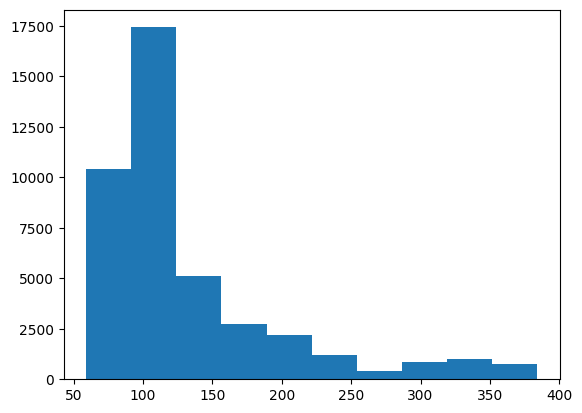

In [21]:
plt.hist(X_train['CRS_ELAPSED_TIME'])
plt.show()

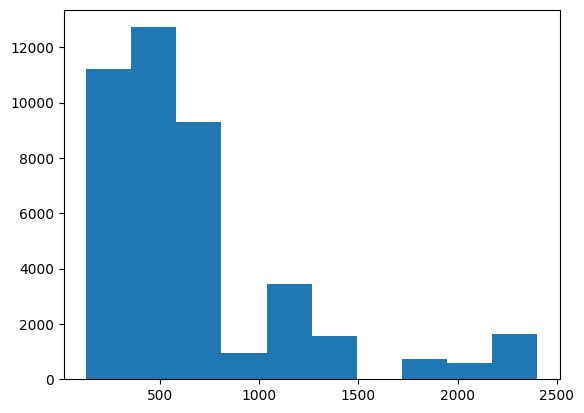

In [22]:
plt.hist(X_train['DISTANCE'])
plt.show()

Since all these have long tails, it makes sense to use a log transformer rather than a standard scaler. We will fit and transform on X_train, and we will transform on X_test.

In [23]:
from sklearn.preprocessing import PowerTransformer
pow_trans0 = PowerTransformer()
X_train['CRS_ELAPSED_TIME_LG'] = pow_trans0.fit_transform(X_train[['CRS_ELAPSED_TIME']])
X_test['CRS_ELAPSED_TIME_LG'] = pow_trans0.transform(X_test[['CRS_ELAPSED_TIME']])

pow_trans1 = PowerTransformer()
X_train['DISTANCE_LG'] = pow_trans1.fit_transform(X_train[['DISTANCE']])
X_test['DISTANCE_LG'] = pow_trans1.transform(X_test[['DISTANCE']])

Despite all the error messages this seems to have worked okay.

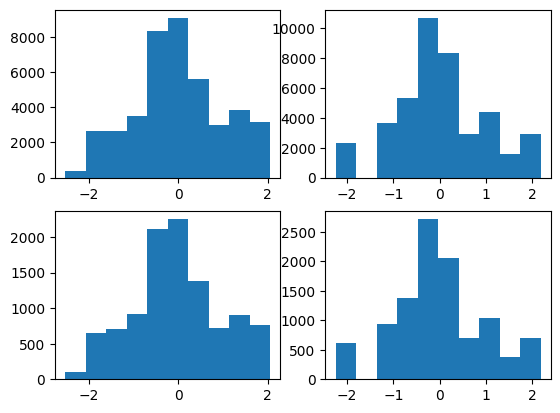

In [24]:
fig, ax = plt. subplots(2, 2)
ax[0, 0].hist(X_train['CRS_ELAPSED_TIME_LG'])
ax[0, 1].hist(X_train['DISTANCE_LG'])
ax[1, 0].hist(X_test['CRS_ELAPSED_TIME_LG'])
ax[1, 1].hist(X_test['DISTANCE_LG'])
plt.show()

Looks better!

In [25]:
X_train.drop(columns=['CRS_ELAPSED_TIME', 'DISTANCE'], inplace=True)
X_test.drop(columns=['CRS_ELAPSED_TIME', 'DISTANCE'], inplace=True)

## Resampling to correct our data imbalance

We have a LOT more flights that leave on time (RESULT==0) than delayed or cancelled (RESULT==[1, 2, 3, 4]). I tried modelling on the imbalanced data but got extremely bad F1 scores. Let's try resampling our data to correct this imbalance.

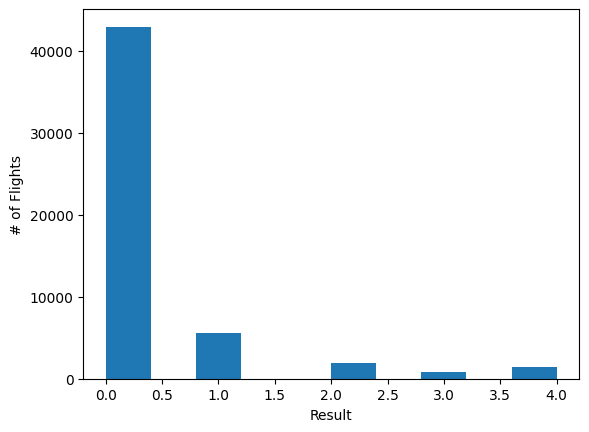

In [26]:
# just showing the visualization before the train/test split

fig, ax = plt.subplots()
ax.hist(df_RDU2['RESULT'])
ax.set_xlabel('Result')
ax.set_ylabel('# of Flights')
plt.show()

In [27]:
df_RDU2['RESULT'].value_counts()

# we have about 43k flights that leave on time, and 11k of everything else

RESULT
0    42945
1     5551
2     1903
4     1470
3      776
Name: count, dtype: int64

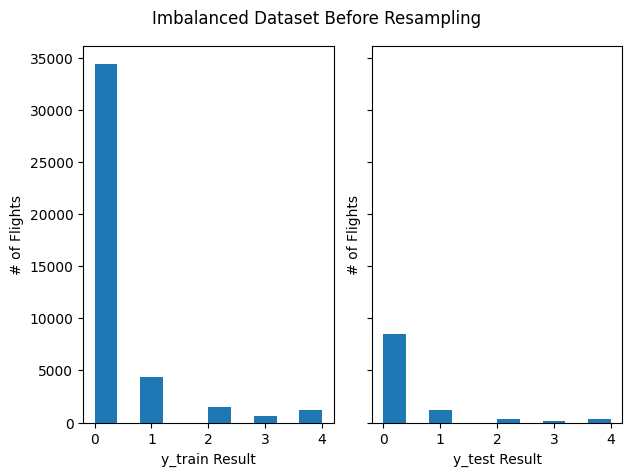

In [28]:
fig, (ax1, ax2) = plt.subplots(1,2, sharey=True)
ax1.hist(y_train)
ax1.set_xlabel('y_train Result')
ax1.set_ylabel('# of Flights')
ax2.hist(y_test)
ax2.set_xlabel('y_test Result')
ax2.set_ylabel('# of Flights')
fig.suptitle('Imbalanced Dataset Before Resampling')
fig.tight_layout(pad=1.0)
plt.show()

In [29]:
np.unique(y_train, return_counts=True)

(array([0, 1, 2, 3, 4], dtype=int64),
 array([34430,  4383,  1534,   604,  1165], dtype=int64))

In [30]:
np.unique(y_test, return_counts=True)

(array([0, 1, 2, 3, 4], dtype=int64),
 array([8515, 1168,  369,  172,  305], dtype=int64))

Let's resample the training set so that we have equal numbers of each result (no delay, delay of 1 hour or less, delay of 2 hours or less, delay of more than 2 hours, cancelled flight). 

We'll use SMOTE to create synthetic data.

In [32]:
import imblearn
print(imblearn.__version__)

0.10.1


In [33]:
# Trying to do this: https://machinelearningmastery.com/multi-class-imbalanced-classification/

from imblearn.over_sampling import SMOTE

# transform the dataset
oversample = SMOTE(random_state=42)
X_train_res, y_train_res = oversample.fit_resample(X_train, y_train)

In [34]:
y_train_res.value_counts()

RESULT
0    34430
1    34430
2    34430
3    34430
4    34430
Name: count, dtype: int64

This is what our data looks like now after resampling! We have 34430 samples for each category.

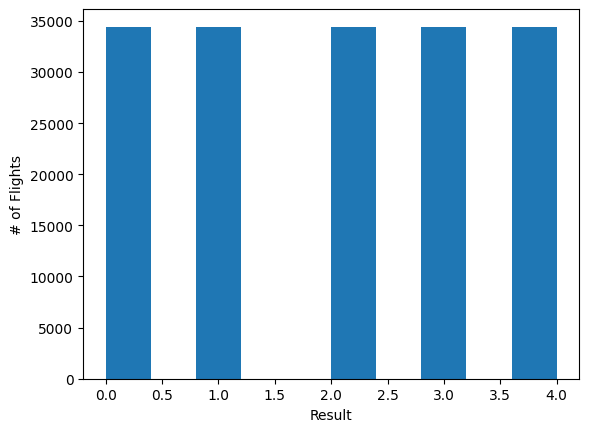

In [35]:
fig, ax = plt.subplots()
ax.hist(y_train_res)
ax.set_xlabel('Result')
ax.set_ylabel('# of Flights')
plt.show()

In [36]:
X_train_res.to_csv('../Data/Final/X_train.csv')
X_test.to_csv('../Data/Final/X_test.csv')
y_train_res.to_csv('../Data/Final/y_train.csv')
y_test.to_csv('../Data/Final/y_test.csv')